In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score


In [8]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

In [9]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [10]:
ruta="/Users/Naye/Documents/python/Seminario-estadista/tarea2/"
base="tabla.xlsx"
df = pd.read_excel(ruta+base, sheet_name=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   _id_           50000 non-null  int64  
 1   _id2_          50000 non-null  int64  
 2   comp_mixto1    50000 non-null  float64
 3   comp_externo1  50000 non-null  float64
 4   comp_externo2  50000 non-null  float64
 5   comp_externo3  50000 non-null  int64  
 6   comp_externo4  50000 non-null  float64
 7   fecha_inicio   50000 non-null  object 
 8   comp_interno1  50000 non-null  float64
 9   comp_interno2  50000 non-null  object 
 10  comp_interno3  50000 non-null  int64  
 11  comp_interno4  50000 non-null  int64  
 12  categoria1     50000 non-null  int64  
 13  categoria2     50000 non-null  int64  
 14  categoria3     50000 non-null  int64  
 15  inversion      50000 non-null  float64
 16  Y              50000 non-null  int64  
dtypes: float64(6), int64(9), object(2)
memory usage: 6

In [11]:
X = df[["_id_","_id2_","comp_mixto1","comp_externo1","comp_externo2","comp_externo3","comp_externo4","comp_interno1","comp_interno2","comp_interno3","comp_interno4","categoria1","categoria2","categoria3","inversion"
,"Y"]].copy()
y = X.pop('Y')


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)

In [13]:
num_features = X_train.select_dtypes(include='number').columns.to_list()
num_features

['_id_',
 '_id2_',
 'comp_mixto1',
 'comp_externo1',
 'comp_externo2',
 'comp_externo3',
 'comp_externo4',
 'comp_interno1',
 'comp_interno3',
 'comp_interno4',
 'categoria1',
 'categoria2',
 'categoria3',
 'inversion']

In [14]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['comp_interno2']

In [15]:
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('onehot', OneHotEncoder(categories=cat_list, sparse=False,
                                        handle_unknown='error', drop='first'))])

In [16]:
preprocessor = ColumnTransformer(transformers=[
               ('numerical', num_pipeline, num_features),
               ('categorical', cat_pipeline, cat_features)],
               remainder='drop')

In [17]:
dec_tree = DecisionTreeClassifier(random_state=42)
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', dec_tree)])


In [76]:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['_id_', '_id2_',
                                                   'comp_mixto1',
                                                   'comp_externo1',
                                                   'comp_externo2',
                                                   'comp_externo3',
                                                   'comp_externo4',
                                                   'comp_interno1',
                                                   'comp_interno3',
                                                   'comp_interno4',
                                                   'categoria1', 'categoria2',
                                 

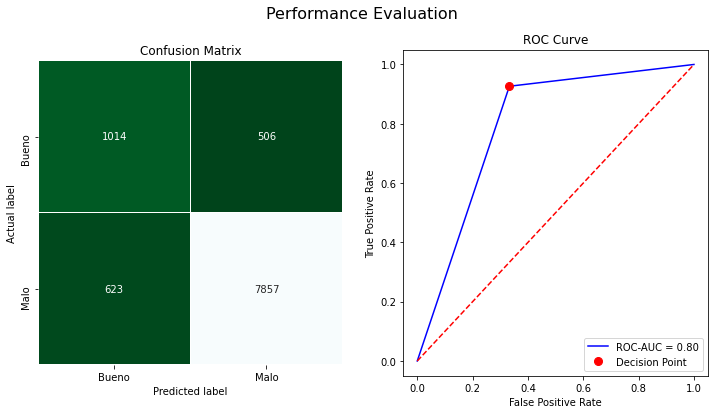

In [77]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(tree_pipeline, X_test,y_test, labels=LABELS,show_plot=True)

In [80]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())])

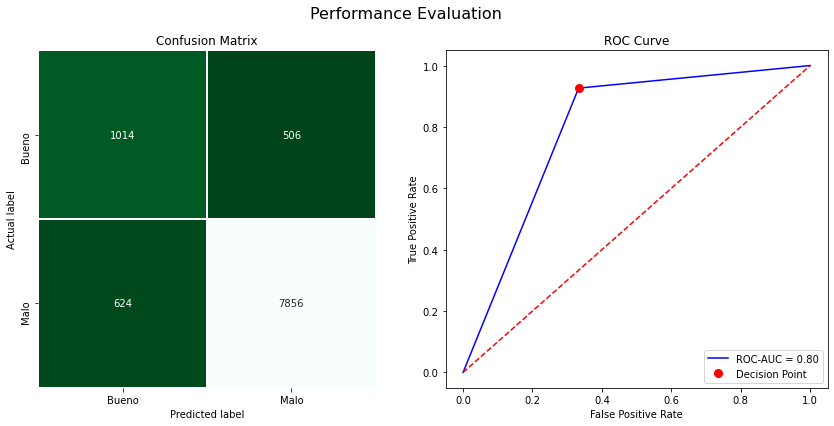

In [81]:
preprocessor = ColumnTransformer(transformers=[('numerical', num_pipeline, num_features),
                                               ('categorical', cat_pipeline, cat_features)],
                                 remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im18.png')
plt.show()

In [84]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.89125 , 0.886   , 0.89025 , 0.89325 , 0.890625])

In [85]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold,
                           scoring=['accuracy', 'precision', 'recall','roc_auc'])

{'fit_time': array([0.71056342, 0.88745403, 0.85247588, 0.74254394, 0.93542552]),
 'score_time': array([0.10293603, 0.08894753, 0.08994508, 0.12492347, 0.10993171]),
 'test_accuracy': array([0.89125 , 0.886   , 0.89025 , 0.89325 , 0.890625]),
 'test_precision': array([0.94082576, 0.9423019 , 0.94048329, 0.94187779, 0.94143135]),
 'test_recall': array([0.9302874 , 0.92202241, 0.92939269, 0.93160377, 0.92880307]),
 'test_roc_auc': array([0.80176921, 0.80352765, 0.80063384, 0.80544004, 0.80321732])}

In [87]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 11),
               'classifier__min_samples_leaf': range(2, 11)}
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['_id_',
                                                                          '_id2_',
                                                                          'comp_mixto1',
                                                                          'comp_externo1'

In [88]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2}
Recall (Training set): 1.0000
Recall (Test set): 1.0000


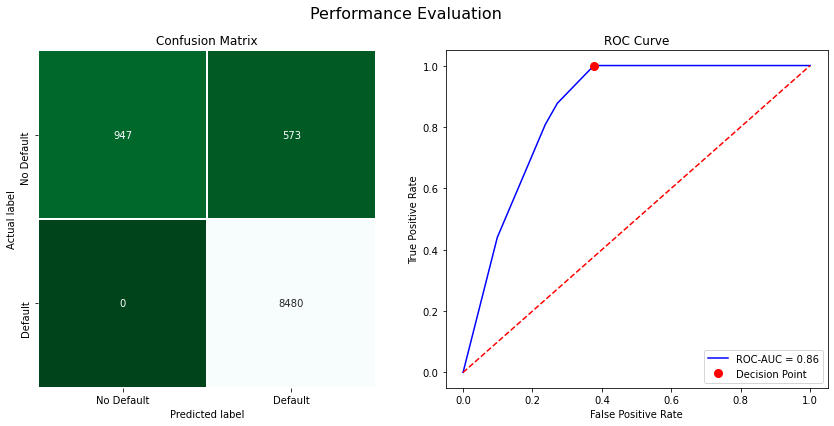

In [89]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
#plt.savefig('images/ch8_im20.png')
plt.show()

In [91]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in range(1, 26):
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeClassifier(criterion='gini',
                                          max_depth=max_depth,
                                          min_samples_leaf=10,
                                          random_state=42)
    tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', reg_tree)])
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [],[], []
    for train_idx, test_idx in k_fold.split(X_train,y_train):
        X_t, y_t,  = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_te, y_te = X_train.iloc[test_idx], y_train.iloc[test_idx]
        tree_pipeline.fit(X_t, y_t)
        train_pred = tree_pipeline.predict_proba(X=X_t)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_t)
        #print(train_score)
        train_scores[max_depth].append(train_score)

        test_pred = tree_pipeline.predict_proba(X=X_te)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_te)
        val_scores[max_depth].append(val_score)  
        #print(val_score)
        leaves[max_depth].append(max_depth)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [92]:
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
bd_leaves = pd.DataFrame(leaves)
leaves

{1: [1, 1, 1, 1, 1],
 2: [2, 2, 2, 2, 2],
 3: [3, 3, 3, 3, 3],
 4: [4, 4, 4, 4, 4],
 5: [5, 5, 5, 5, 5],
 6: [6, 6, 6, 6, 6],
 7: [7, 7, 7, 7, 7],
 8: [8, 8, 8, 8, 8],
 9: [9, 9, 9, 9, 9],
 10: [10, 10, 10, 10, 10],
 11: [11, 11, 11, 11, 11],
 12: [12, 12, 12, 12, 12],
 13: [13, 13, 13, 13, 13],
 14: [14, 14, 14, 14, 14],
 15: [15, 15, 15, 15, 15],
 16: [16, 16, 16, 16, 16],
 17: [17, 17, 17, 17, 17],
 18: [18, 18, 18, 18, 18],
 19: [19, 19, 19, 19, 19],
 20: [20, 20, 20, 20, 20],
 21: [21, 21, 21, 21, 21],
 22: [22, 22, 22, 22, 22],
 23: [23, 23, 23, 23, 23],
 24: [24, 24, 24, 24, 24],
 25: [25, 25, 25, 25, 25]}

In [93]:
clf_train_scores

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,0.818257,0.847169,0.854908,0.866700,0.873876,0.881826,0.888381,0.896475,0.907419,0.918763,...,0.970561,0.972948,0.974616,0.976167,0.976878,0.977236,0.977532,0.977652,0.977700,0.977724
1,0.818014,0.848941,0.853243,0.863299,0.873213,0.880271,0.887452,0.896080,0.907270,0.919955,...,0.971561,0.973537,0.975022,0.976041,0.976581,0.976892,0.977133,0.977176,0.977221,0.977228
2,0.819042,0.845307,0.854285,0.868026,0.875348,0.883791,0.888684,0.895188,0.904942,0.915959,...,0.969295,0.972512,0.974288,0.975469,0.976489,0.977067,0.977345,0.977465,0.977515,0.977541
3,0.816677,0.845357,0.858406,0.870596,0.876588,0.883475,0.890477,0.897088,0.907392,0.919399,...,0.972412,0.975008,0.976391,0.977092,0.977427,0.977772,0.977988,0.978044,0.978046,0.978046
4,0.816677,0.845503,0.857060,0.867323,0.871967,0.877489,0.887724,0.896073,0.906041,0.920405,...,0.974328,0.975836,0.976867,0.977236,0.977409,0.977460,0.977465,0.977465,0.977465,0.977465


In [94]:
clf_valid_scores

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,0.815638,0.839383,0.847272,0.867089,0.870652,0.876833,0.877477,0.875271,0.865844,0.866006,...,0.840323,0.839618,0.838212,0.837923,0.838630,0.840085,0.840824,0.841207,0.839462,0.839972
1,0.816612,0.842620,0.845060,0.854943,0.866690,0.865508,0.864170,0.862351,0.855690,0.856061,...,0.833642,0.833836,0.836843,0.834677,0.836965,0.839010,0.837664,0.837454,0.837034,0.837416
2,0.812500,0.848717,0.851838,0.858383,0.862685,0.867813,0.869331,0.863566,0.855824,0.851004,...,0.841787,0.841174,0.838360,0.839045,0.838941,0.838741,0.840692,0.840815,0.840372,0.840896
3,0.821957,0.848458,0.856748,0.865324,0.867133,0.867569,0.868584,0.861105,0.853199,0.847756,...,0.837839,0.837787,0.839770,0.841071,0.843636,0.842606,0.842921,0.843678,0.843889,0.843889
4,0.821546,0.847425,0.854874,0.861829,0.865618,0.868694,0.870259,0.872381,0.865713,0.862294,...,0.834795,0.840384,0.840146,0.841412,0.840043,0.841084,0.841015,0.841015,0.841015,0.841015


In [95]:
roc_entrenamiento=[]
for c in clf_train_scores.columns:
    promedio_roc=mean(clf_train_scores[c])
    roc_entrenamiento.append(promedio_roc)
    
roc_validacion=[]
for c in clf_valid_scores.columns:
    promedio_roc=mean(clf_valid_scores[c])
    roc_validacion.append(promedio_roc)

prof=[]
for c in bd_leaves.columns:
    id_=mean(bd_leaves[c])
    prof.append(id_)

In [96]:
roc_entrenamiento

[0.817733158273537,
 0.8464555386483139,
 0.8555802313263803,
 0.8671888993195418,
 0.8741983464920864,
 0.881370457156831,
 0.888543547752049,
 0.896180787192818,
 0.906612850810439,
 0.9188959369642973,
 0.931887207063904,
 0.9436804647912276,
 0.9541085168690955,
 0.9621825753153583,
 0.9679532212717682,
 0.9716314919079588,
 0.9739682187266311,
 0.9754369921892225,
 0.9764010844814294,
 0.9769568370885248,
 0.9772855778443983,
 0.9774927958000041,
 0.9775603691494716,
 0.9775893633652,
 0.9776008790310323]

In [97]:
roc_validacion

[0.8176505983322503,
 0.8453207315770681,
 0.8511585274647094,
 0.8615136868060567,
 0.8665556596783919,
 0.8692833899447784,
 0.869964318879029,
 0.866934907448661,
 0.8592540300784786,
 0.856624363940593,
 0.8491515332585859,
 0.8453932147023367,
 0.8424323540295211,
 0.8394354919276319,
 0.8382774546105194,
 0.8376771112372575,
 0.8385597892968623,
 0.8386662261193667,
 0.838825775554174,
 0.8396430632736054,
 0.8403052154102646,
 0.8406231343714946,
 0.8408337603883537,
 0.8403544805893798,
 0.8406378448108031]

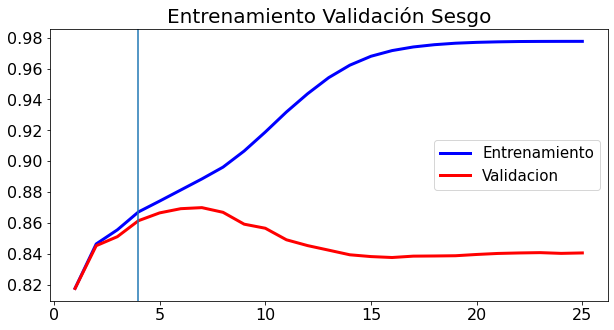

In [98]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Entrenamiento Validación Sesgo",fontsize=20)
ax.plot(prof,roc_entrenamiento,color="blue",linewidth=3,label="Entrenamiento")
ax.plot(prof,roc_validacion,color="red",linewidth=3,label="Validacion")
#gca().yaxis.set_major_formatter("{x:,.0%}")
xticks(fontsize=16)
yticks(fontsize=16)
axvline(4)
legend(fontsize=15)
show()